In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt

In [2]:
from sklearn.neighbors import NearestNeighbors

In [3]:
from src.envs.cancer import CancerSim, PolicyCancer

In [4]:
# with open("data/cancer_pcv_train_episodes", 'rb') as f:
#     train_dataset = pickle.load(f)
# with open("data/cancer_pcv_val_episodes", 'rb') as f:
#     val_dataset = pickle.load(f)

In [4]:
from src.offline_ql import discrete_PQL
from src.offline_pg import ISPG

In [5]:
def online_evaluate(env, policy, trees, sample_size=1000):
    returns = []
    action_dict = dict()
    avg_treatment = []
    change_in_mtd = []
    for i in range(sample_size):
        obs = env.reset()
        done = False
        rt = 0
        t = 0
        treatment = []
        init_mtd = obs[1]
        while not done:
            nn_action_dist = get_nn_action_dist(obs, trees)
            pibs = PolicyCancer().return_probs(obs, t)
            a = policy.select_action(obs, pibs, nn_action_dist)
            t += 1
            obs, reward, done, _ = env.step(a)
            rt += reward
            treatment.append(a)
        end_mtd = obs[1]
        returns.append(rt)
        avg_treatment.append(treatment)
        change_in_mtd.append(100*(end_mtd-init_mtd)/init_mtd)
    avg_treatment = np.array(avg_treatment).mean(axis=0)
    avg_change_in_mtd = np.mean(change_in_mtd)
    return np.mean(returns), np.std(returns), avg_treatment, avg_change_in_mtd


def get_nn_action_dist(obs, trees):
    nn_action_dist = np.zeros(len(trees))
    for a in range(len(trees)):
        nn_action_dist[a] = (trees[a].kneighbors(obs.reshape(1,-1))[0].item()**2)/obs.size
    return nn_action_dist


def construct_nearest_neighbor_trees(observations, actions, num_actions=2):
    trees = dict()
    for a in range(num_actions):
        trees[a] = NearestNeighbors(n_neighbors=1)
        is_action = (np.squeeze(actions,axis=-1) == a)
        trees[a].fit(observations[is_action, :])
    return trees

def test_fix_policy(env, eps=0, n=1000):
    policy = PolicyCancer(eps_behavior=eps)
    rewards = []
    for i in range(n):
        obs = env.reset()
        t = 0
        reward = 0
        done = False
        while not done:
            a = policy(obs, t)
            obs, rt, done, _ = env.step(a)
            t += 1
            reward += rt
        rewards.append(reward)
    return np.mean(rewards), np.std(rewards)

In [6]:
def wis_fix_policy(dataset):
    policy = PolicyCancer(eps_behavior=0.01)

    n = dataset["observations"].shape[0]
    horizon = dataset["observations"].shape[1]
    weights = np.ones((n, horizon))
    
    rewards = dataset["rewards"][:,:,0]
    
    for idx in range(n):
        last = 1
        for t in range(horizon):
            pie = policy.return_probs(dataset["observations"][idx,t,:], t)
            a = dataset["actions"][idx,t,0]
            
            weights[idx, t] = last * (pie[a] / dataset["pibs"][idx, t, a])
            last = weights[idx, t]

            if not dataset["not_done"][idx, t, 0]:
                weights[idx, t+1:] = weights[idx, t]
                break
    
    weights = np.clip(weights, 0, 1e3)
    weights_norm = weights.sum(axis=0)
    weights /= weights_norm
    estm = (weights[:,-1] * rewards.sum(axis=-1)).sum()
    
    return estm
    

In [7]:
def get_model_from_param(param):
    
    FEATURES_UB = [3.25401319, 51.84731224, 30.]
    # FEATURES_UB = [3.18970173,  7.85591301, 44.83595683, 30.64735325, 30.]
    
    if param["name"] == "PG_mask":
        settings = f"PG_{param['env']}_masknn_action_dist_weightedTrueam0.0"\
                   f"thresh{param['thresh']}var{param['var_coeff']}clip0.01seed{param['seed']}"
        model = ISPG(state_dim=3, num_actions=2, device="cpu", hidden_dim=32,
                     threshold=param['thresh'], action_mask_type="nn_action_dist")
        model.load(f"models/{settings}_best_")
        val_score = np.load(f"./results/{settings}_val_wis_scores.npy")
        train_score = np.load(f"./results/{settings}_train_wis_scores.npy")[:,0]
        test_score = np.load(f"./results/{settings}_true_scores.npy") 
    
    elif param["name"] == "PG_nomask":
        settings = f"PG_{param['env']}_maskstep_weightedTrueam0.0"\
                   f"thresh{param['thresh']}var{param['var_coeff']}clip0.01seed{param['seed']}"
        model = ISPG(state_dim=3, num_actions=2, device="cpu", hidden_dim=32,
                     threshold=param['thresh'], action_mask_type="step")
        model.load(f"models/{settings}_best_")
        val_score = np.load(f"./results/{settings}_val_wis_scores.npy")
        train_score = np.load(f"./results/{settings}_train_wis_scores.npy")[:,0]
        test_score = np.load(f"./results/{settings}_true_scores.npy") 
    
    elif param["name"] == "PG_pib_mask":
        model = ISPG(state_dim=3, num_actions=2, device="cpu", hidden_dim=32,
                     threshold=param['thresh'], action_mask_type="step")
        val_score = None
        train_score = None
        test_score = None
    
    elif param["name"] == "BCQ":
        settings = f"BCQ_{param['env']}_thresh{param['thresh']}_seed{param['seed']}"
        model = discrete_PQL(state_dim=3, num_actions=2, device="cpu", state_clipping=False, hidden_dim=32,
                             max_state=FEATURES_UB, action_threshold=param['thresh'], log_pibs=True)
        model.load(f"models/{settings}_best_")
        val_score = np.load(f"./results/{settings}_val_scores.npy")
        train_score = np.load(f"./results/{settings}_q_scores.npy")
        test_score = np.load(f"./results/{settings}_true_scores.npy") 
    
    elif param["name"] == "PQL":
        settings = f"PQL_{param['env']}_thresh{param['thresh']}_seed{param['seed']}"
        model = discrete_PQL(state_dim=3, num_actions=2, device="cpu", state_clipping=True, hidden_dim=32,
                             max_state=FEATURES_UB, action_threshold=param['thresh'], log_pibs=True)
        model.load(f"models/{settings}_best_")
        val_score = np.load(f"./results/{settings}_val_scores.npy")
        train_score = np.load(f"./results/{settings}_q_scores.npy")
        test_score = np.load(f"./results/{settings}_true_scores.npy") 
    
    return model, val_score, train_score, test_score

In [58]:
def get_model_from_param(param):
    
    #FEATURES_UB = [3.25401319, 51.84731224, 30.]
    state_dim = 5
    FEATURES_UB = [3.18970173,  7.85591301, 44.83595683, 30.64735325, 30.]
    
    if param["name"] == "PG_mask":
        settings = f"PG_{param['env']}_masknn_action_dist_"\
                   f"thresh{param['thresh']}var{param['var_coeff']}seed{param['seed']}"
        model = ISPG(state_dim=state_dim, num_actions=2, device="cpu", hidden_dim=32,
                     threshold=param['thresh'], action_mask_type="nn_action_dist")
        model.load(f"models/{settings}_best_")
        val_score = np.load(f"./results/{settings}_val_wis_scores.npy")
        train_score = np.load(f"./results/{settings}_train_wis_scores.npy")[:,0]
    
    elif param["name"] == "PG_nomask":
        settings = f"PG_{param['env']}_maskstep_"\
                   f"thresh{param['thresh']}var{param['var_coeff']}seed{param['seed']}"
        model = ISPG(state_dim=state_dim, num_actions=2, device="cpu", hidden_dim=32,
                     threshold=param['thresh'], action_mask_type="step")
        model.load(f"models/{settings}_best_")
        val_score = np.load(f"./results/{settings}_val_wis_scores.npy")
        train_score = np.load(f"./results/{settings}_train_wis_scores.npy")[:,0]
    
    elif param["name"] == "PG_pib_mask":
        model = ISPG(state_dim=state_dim, num_actions=2, device="cpu", hidden_dim=32,
                     threshold=param['thresh'], action_mask_type="step")
        val_score = None
        train_score = None
        test_score = None
    
    elif param["name"] == "BCQ":
        settings = f"BCQ_{param['env']}_thresh{param['thresh']}_beta2.0_seed{param['seed']}"
        model = discrete_PQL(state_dim=state_dim, num_actions=2, device="cpu", state_clipping=False, hidden_dim=32,
                             max_state=FEATURES_UB, action_threshold=param['thresh'], log_pibs=True)
        model.load(f"models/{settings}_best_")
        val_score = np.load(f"./results/{settings}_val_scores.npy")
        train_score = np.expand_dims(np.load(f"./results/{settings}_q_scores.npy"), axis=1)
        #val_score = val_score[:5,:]
        #val_score = np.hstack((train_score, val_score))
    
    elif param["name"] == "PQL":
        settings = f"PQL_{param['env']}_thresh{param['thresh']}_beta{param['beta']}_seed{param['seed']}"
        model = discrete_PQL(state_dim=state_dim, num_actions=2, device="cpu", state_clipping=True, hidden_dim=32,
                             max_state=FEATURES_UB, action_threshold=param['thresh'], log_pibs=True)
        model.load(f"models/{settings}_best_")
        val_score = np.load(f"./results/{settings}_val_scores.npy")
        train_score = np.expand_dims(np.load(f"./results/{settings}_q_scores.npy"),axis=1)
        #val_score = val_score[:5,:]
        #val_score = np.hstack((train_score, val_score))
    
    test_score = np.load(f"./results/{settings}_true_scores.npy")
    return model, val_score, train_score, test_score

In [8]:
def get_best_hp(env, alg, verbose=True):
    #var_coeff = 0.0
    var_coeff_list = [0.0, 0.1, 1.0]
    seeds = [1,2,3,4,5]
    if alg == "PG_mask":
        threshold_list = [0.05, 0.1, 0.5]
    elif alg == "PG_nomask":
        threshold_list = [0.0]
    elif alg == "PG_pib_mask":
        with open(f"data/{env_name}_train_episodes", 'rb') as f:
            train_dataset = pickle.load(f)
        with open(f"data/{env_name}_val_episodes", 'rb') as f:
            val_dataset = pickle.load(f)
        return {"name": alg, "env": env, "thresh": 0.2, "var_coeff": 0, "seed": 0}, wis_fix_policy(val_dataset), wis_fix_policy(val_dataset)
    elif alg == "BCQ":
        var_coeff_list = [0.0]
        threshold_list = [0.0, 0.25]
    elif alg == "PQL":
        var_coeff_list = [1.0, 2.0, 5.0]
        threshold_list = [0.0, 0.25]
    best_wis = -100
    for var_coeff in var_coeff_list:
        for threshold in threshold_list:
            for seed in seeds:
                if alg == "PQL":
                    param = {"name": alg, "env": env, "thresh": threshold, "beta": var_coeff, "seed": seed}
                else:
                    param = {"name": alg, "env": env, "thresh": threshold, "var_coeff": var_coeff, "seed": seed}
                model, score, train_score, _ = get_model_from_param(param)
        
                wis_pie = score[:,0].max()
                ESS = score[np.argmax(score[:,0]),-1]
                train = train_score[np.argmax(score[:,0])]
            
                if wis_pie > best_wis:
                    best_wis = wis_pie
                    best_train = train
                    best_param = param
                    if verbose:
                        print("New wis:", round(wis_pie, 2), "ESS:", round(ESS, 2), "at:", param)
    return best_param, best_wis, best_train
        

In [121]:
env_list = ["cancer_mdp_pcv1", "cancer_mdp_pcv2", "cancer_mdp_pcv3", "cancer_mdp_pcv4", "cancer_mdp_pcv5"]
env = CancerSim(dose_penalty=1.0, therapy_type="PCV", env_seed=None, max_steps=30, state_dim=5)

#env_list = ["cancer_pcv1", "cancer_pcv2", "cancer_pcv3", "cancer_pcv4", "cancer_pcv5"]
#env = CancerSim(dose_penalty=1.0, therapy_type="PCV", env_seed=None, max_steps=30, state_dim=3)

algo_list = ["PG_mask", "PG_nomask", "PG_pib_mask", "BCQ", "PQL"]

test_results = np.zeros((len(algo_list), len(env_list)))
train_results = np.zeros((len(algo_list), len(env_list)))
valid_results = np.zeros((len(algo_list), len(env_list)))
treatment_logs = np.zeros((len(algo_list), len(env_list), 30))
mtd_changes = np.zeros((len(algo_list), len(env_list)))



for j,env_name in enumerate(env_list):
    with open(f"data/{env_name}_train_episodes", 'rb') as f:
        train_dataset = pickle.load(f)
    trees = construct_nearest_neighbor_trees(train_dataset["observations"],train_dataset["actions"])
    for i,algo in enumerate(algo_list):
        param, val, train = get_best_hp(env_name, algo)
        model, _, _, _ = get_model_from_param(param)
        test, _, treatment_log, mtd_change = online_evaluate(env, model, trees, sample_size=100)
        print("Online Test:", env_name, algo, test)
        
        test_results[i,j] = test
        train_results[i,j] = train
        valid_results[i,j] = val
        treatment_logs[i,j,:] = treatment_log
        mtd_changes[i,j] = mtd_change

New wis: 2.2 ESS: 2.01 at: {'name': 'PG_mask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.05, 'var_coeff': 0.0, 'seed': 1}
New wis: 2.34 ESS: 1.89 at: {'name': 'PG_mask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.05, 'var_coeff': 0.0, 'seed': 3}
New wis: 2.64 ESS: 1.34 at: {'name': 'PG_mask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.05, 'var_coeff': 0.0, 'seed': 5}
New wis: 2.96 ESS: 1.26 at: {'name': 'PG_mask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.5, 'var_coeff': 0.0, 'seed': 5}
Online Test: cancer_mdp_pcv1 PG_mask 0.13412338095166182
New wis: 2.32 ESS: 2.31 at: {'name': 'PG_nomask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.0, 'var_coeff': 0.0, 'seed': 1}
New wis: 3.0 ESS: 1.18 at: {'name': 'PG_nomask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.0, 'var_coeff': 0.0, 'seed': 5}
New wis: 3.01 ESS: 1.16 at: {'name': 'PG_nomask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.0, 'var_coeff': 0.1, 'seed': 5}
New wis: 3.01 ESS: 1.15 at: {'name': 'PG_nomask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.0, 'var_coeff': 1.0, '

Online Test: cancer_mdp_pcv5 BCQ 2.4223678042389207
New wis: 0.75 ESS: 1.08 at: {'name': 'PQL', 'env': 'cancer_mdp_pcv5', 'thresh': 0.0, 'beta': 1.0, 'seed': 1}
New wis: 1.52 ESS: 1.01 at: {'name': 'PQL', 'env': 'cancer_mdp_pcv5', 'thresh': 0.0, 'beta': 1.0, 'seed': 2}
New wis: 1.52 ESS: 1.01 at: {'name': 'PQL', 'env': 'cancer_mdp_pcv5', 'thresh': 0.0, 'beta': 2.0, 'seed': 2}
Online Test: cancer_mdp_pcv5 PQL 2.9694913512342267


In [112]:
v_max = 2.5
v_min = -20.0

In [113]:
final_test_results = 100*(test_results-v_min)/(v_max-v_min)
final_valid_results = 100*(valid_results-v_min)/(v_max-v_min)
final_train_results = 100*(train_results-v_min)/(v_max-v_min)

In [114]:
np.set_printoptions(precision=2, linewidth=100)

In [115]:
final_test_results[:,:].mean(axis=-1)

array([89.52, 78.79, 69.46, 95.64, 96.88])

In [116]:
final_test_results.std(axis=-1)/np.sqrt(5)

array([1.55, 6.42, 0.26, 4.64, 3.76])

In [117]:
final_valid_results.mean(axis=-1) - final_test_results.mean(axis=-1)

array([ 5.16, 14.93, -0.69,  0.55, -0.26])

In [118]:
(final_valid_results - final_test_results).std(axis=-1)/np.sqrt(5)

array([1.78, 5.71, 0.81, 5.12, 4.18])

In [18]:
treatment_logs[:,:,:].sum(axis=-1).mean(axis=1)

array([7.61, 3.23, 9.  , 0.4 ])

In [19]:
treatment_logs[:,:,:].sum(axis=-1).std(axis=1)/np.sqrt(5)

array([1.69, 0.49, 0.  , 0.36])

In [15]:
mtd_changes.mean(axis=-1)

array([-53.43,   6.44, -64.46,  89.81])

In [16]:
mtd_changes.std(axis=-1)/np.sqrt(5)

array([ 9.95, 12.99,  0.11, 10.72])

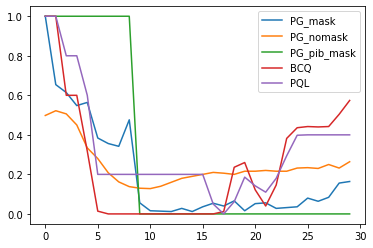

In [92]:
plt.plot(treatment_logs[:,:,:].mean(axis=1).transpose())
plt.legend(algo_list)
#plt.yscale("log")
plt.show()

In [37]:
def compute_is_weights(dataset, q_policy):
    n = dataset["observations"].shape[0]
    horizon = dataset["observations"].shape[1]
    
    rewards = dataset["rewards"][:,:,0]
    
    pies = np.zeros((n, horizon))
    pibs = np.zeros((n, horizon))
    length = horizon*np.ones((n))
    
    for idx in range(n):
        for t in range(horizon):
            pie = q_policy.get_prob(dataset["observations"][idx,t,:], dataset["pibs"][idx,t,:], 
                                    dataset["nn_action_dist"][idx,t,:])
            a = dataset["actions"][idx,t,0]
            
            pies[idx,t] = pie[a]
            pibs[idx,t] = dataset["pibs"][idx,t,a]
    return pibs, pies, rewards, length.astype(int)

In [47]:
def wis_weights_on_neg_rewards(pibs, pies, rewards, length, weighted=True):
    n = pibs.shape[0]
    weights = np.ones((n,30))
    
    for i in range(n):
        last = 1
        for t in range(int(length[i])):
            weights[i,t] = last*(pies[i,t]/pibs[i,t])    
            last = weights[i,t]
        weights[i,length[i]:] = weights[i,length[i]-1]
    weights = np.clip(weights, 0, 1e3)
    if weighted:
        weights_norm = weights.sum(axis=0)
    else:
        weights_norm = weights.shape[0]
    weights /= weights_norm
    reward_filter = (rewards.sum(axis=-1) < -2).astype(float)
    
    return (weights[:,-1] * reward_filter).sum(axis=0), reward_filter, weights[:,-1]

In [14]:
with open(f"data/cancer_pcv1_val_episodes", 'rb') as f:
        train_dataset = pickle.load(f)

In [15]:
train_dataset.keys()

dict_keys(['observations', 'actions', 'rewards', 'sparse_rewards', 'dense_rewards', 'not_done', 'pibs', 'nn_action_dist'])

In [45]:
#plt.hist(train_dataset['rewards'][:,:,0].sum(axis=-1))
reward_filter = (train_dataset['rewards'][:,:,0].sum(axis=-1) < -2).astype(float)

In [46]:
reward_filter.mean()

0.95

In [59]:
env_list = ["cancer_mdp_pcv1", "cancer_mdp_pcv2", "cancer_mdp_pcv3", "cancer_mdp_pcv4", "cancer_mdp_pcv5"]
env = CancerSim(dose_penalty=1.0, therapy_type="PCV", env_seed=None, max_steps=30, state_dim=5)

#env_list = ["cancer_pcv1", "cancer_pcv2", "cancer_pcv3", "cancer_pcv4", "cancer_pcv5"]
#env = CancerSim(dose_penalty=1.0, therapy_type="PCV", env_seed=None, max_steps=30, state_dim=3)

algo_list = ["PG_mask", "PG_nomask", "BCQ", "PQL"]

weights_results = np.zeros((len(algo_list), len(env_list)))

for j,env_name in enumerate(env_list):
    with open(f"data/{env_name}_train_episodes", 'rb') as f:
        train_dataset = pickle.load(f)
    with open(f"data/{env_name}_val_episodes", 'rb') as f:
        val_dataset = pickle.load(f)
    trees = construct_nearest_neighbor_trees(train_dataset["observations"],train_dataset["actions"])
    for i,algo in enumerate(algo_list):
        param, val, train = get_best_hp(env_name, algo)
        model, _, _, _ = get_model_from_param(param)
        pibs, pies, rewards, length = compute_is_weights(train_dataset, model)
        weights_sum, reward_filter, weights = wis_weights_on_neg_rewards(pibs, pies, rewards, length)
        print("Neg-reward weights:", env_name, algo, weights_sum, ", neg rewards:", reward_filter.mean())
        weights_results[i,j] = weights_sum

New wis: 2.2 ESS: 2.01 at: {'name': 'PG_mask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.05, 'var_coeff': 0.0, 'seed': 1}
New wis: 2.34 ESS: 1.89 at: {'name': 'PG_mask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.05, 'var_coeff': 0.0, 'seed': 3}
New wis: 2.64 ESS: 1.34 at: {'name': 'PG_mask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.05, 'var_coeff': 0.0, 'seed': 5}
New wis: 2.96 ESS: 1.26 at: {'name': 'PG_mask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.5, 'var_coeff': 0.0, 'seed': 5}
Neg-reward weights: cancer_mdp_pcv1 PG_mask 1.4842282765434383e-06 , neg rewards: 0.937
New wis: 2.32 ESS: 2.31 at: {'name': 'PG_nomask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.0, 'var_coeff': 0.0, 'seed': 1}
New wis: 3.0 ESS: 1.18 at: {'name': 'PG_nomask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.0, 'var_coeff': 0.0, 'seed': 5}
New wis: 3.01 ESS: 1.16 at: {'name': 'PG_nomask', 'env': 'cancer_mdp_pcv1', 'thresh': 0.0, 'var_coeff': 0.1, 'seed': 5}
New wis: 3.01 ESS: 1.15 at: {'name': 'PG_nomask', 'env': 'cancer_mdp_pcv1', 'th

Neg-reward weights: cancer_mdp_pcv5 BCQ 0.005687385065999652 , neg rewards: 0.933
New wis: 0.75 ESS: 1.08 at: {'name': 'PQL', 'env': 'cancer_mdp_pcv5', 'thresh': 0.0, 'beta': 1.0, 'seed': 1}
New wis: 1.52 ESS: 1.01 at: {'name': 'PQL', 'env': 'cancer_mdp_pcv5', 'thresh': 0.0, 'beta': 1.0, 'seed': 2}
New wis: 1.52 ESS: 1.01 at: {'name': 'PQL', 'env': 'cancer_mdp_pcv5', 'thresh': 0.0, 'beta': 2.0, 'seed': 2}
Neg-reward weights: cancer_mdp_pcv5 PQL 0.0004560516525234003 , neg rewards: 0.933


In [51]:
val_weights = weights_results.mean(axis=-1)

In [56]:
val_weights

array([0.01990315, 0.0371038 , 0.00487675, 0.0151123 ])

In [61]:
# Non MDP

In [55]:
train_weights = weights_results.mean(axis=-1)
train_weights

array([0.05499454, 0.0056951 , 0.0003608 , 0.00514889])

In [62]:
# MDP

In [60]:
train_weights = weights_results.mean(axis=-1)
train_weights

array([0.0979573 , 0.00041803, 0.08392234, 0.1242368 ])

## Val-Test correlation

In [126]:
def get_all_checkpoints(env, alg, verbose=True):
    #var_coeff = 0.0
    var_coeff_list = [0.0, 0.1, 1.0]
    seeds = [1,2,3,4,5]
    if alg == "PG_mask":
        threshold_list = [0.05, 0.1, 0.5]
    elif alg == "PG_nomask":
        threshold_list = [0.0]
    elif alg == "PG_pib_mask":
        with open(f"data/{env_name}_train_episodes", 'rb') as f:
            train_dataset = pickle.load(f)
        with open(f"data/{env_name}_val_episodes", 'rb') as f:
            val_dataset = pickle.load(f)
        return {"name": alg, "env": env, "thresh": 0.2, "var_coeff": 0, "seed": 0}, wis_fix_policy(val_dataset), wis_fix_policy(val_dataset)
    elif alg == "BCQ":
        var_coeff_list = [0.0]
        threshold_list = [0.0, 0.25]
    elif alg == "PQL":
        var_coeff_list = [1.0, 2.0, 5.0]
        threshold_list = [0.0, 0.25]
    best_wis = -100
    score_list = np.array([])
    test_score_list = np.array([])
    for var_coeff in var_coeff_list:
        for threshold in threshold_list:
            for seed in seeds:
                if alg == "PQL":
                    param = {"name": alg, "env": env, "thresh": threshold, "beta": var_coeff, "seed": seed}
                else:
                    param = {"name": alg, "env": env, "thresh": threshold, "var_coeff": var_coeff, "seed": seed}
                model, score, train_score, test_score = get_model_from_param(param)
        
                score_list = np.append(score_list, score[:,0])
                test_score_list = np.append(test_score_list, test_score)
    return score_list, test_score_list
        

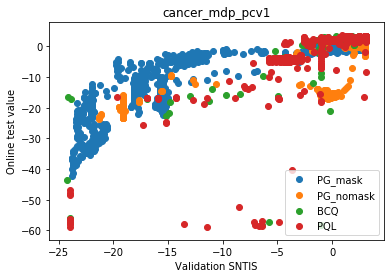

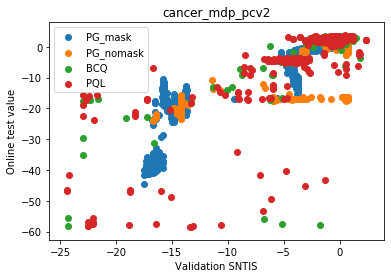

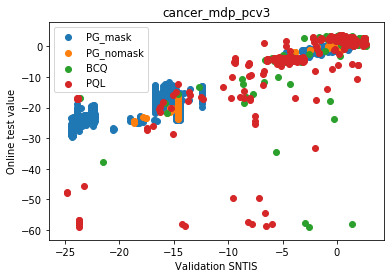

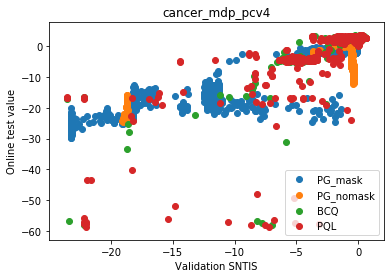

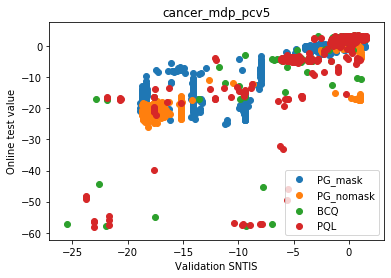

In [135]:
env_list = ["cancer_mdp_pcv1", "cancer_mdp_pcv2", "cancer_mdp_pcv3", "cancer_mdp_pcv4", "cancer_mdp_pcv5"]
algo_list = ["PG_mask", "PG_nomask", "BCQ", "PQL"]
for j,env_name in enumerate(env_list):
    plt.figure()
    for i,algo in enumerate(algo_list):
        score, test_score = get_all_checkpoints(env_name, algo)
        plt.scatter(score, test_score, label=algo)
    plt.xlabel("Validation SNTIS")
    plt.ylabel("Online test value")
    plt.legend()
    #plt.ylim([-20,3])
    plt.title(env_name)
    plt.savefig("val_test_env"+str(j)+".png")
        